<a href="https://colab.research.google.com/github/KetakiN/Springboard/blob/main/NYSDOH_initial_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier



In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


In [3]:
df=pd.read_csv('/content/sample_data/nysdoh_feature.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'Hospital_Service_Area', 'Hospital_County',
       'Facility_Name', 'Age_Group', 'Zip_Code___3_digits', 'Gender', 'Race',
       'Length_of_Stay', 'Type_of_Admission', 'CCS_Diagnosis_Code',
       'CCS_Diagnosis_Description', 'CCS_Procedure_Code',
       'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator', 'length_groups'],
      dtype='object')

In [5]:
df=df.drop('Unnamed: 0',axis=1)

In [6]:
#Select columns for modelling and drop others, note the largest group for procedure code is no procedure, for modelling, diagnosis will be taken into account
X=df.drop(['Zip_Code___3_digits','length_groups','Length_of_Stay','CCS_Procedure_Code', 'CCS_Procedure_Description','CCS_Diagnosis_Code'],axis=1)

In [7]:
#create dummy variables for categorical features in X
X=pd.get_dummies(X,drop_first=True)
X.shape

(13763, 176)

In [8]:
X.head()

,Age_Group,Hospital_Service_Area_Central NY,Hospital_Service_Area_Finger Lakes,Hospital_Service_Area_Southern Tier,Hospital_Service_Area_Western NY,Hospital_County_Allegany,Hospital_County_Broome,Hospital_County_Cattaraugus,Hospital_County_Cayuga,Hospital_County_Chautauqua,Hospital_County_Chemung,Hospital_County_Chenango,Hospital_County_Clinton,Hospital_County_Columbia,Hospital_County_Cortland,Hospital_County_Delaware,Hospital_County_Erie,Hospital_County_Essex,Hospital_County_Franklin,Hospital_County_Fulton,Hospital_County_Genesee,Hospital_County_Herkimer,Hospital_County_Jefferson,Hospital_County_Lewis,Hospital_County_Livingston,Hospital_County_Madison,Hospital_County_Monroe,Hospital_County_Montgomery,Hospital_County_Niagara,Hospital_County_Oneida,Hospital_County_Onondaga,Hospital_County_Ontario,Hospital_County_Orleans,Hospital_County_Oswego,Hospital_County_Otsego,Hospital_County_Rensselaer,Hospital_County_Saratoga,Hospital_County_Schenectady,Hospital_County_Schuyler,Hospital_County_St Lawrence,...,Facility_Name_University Hospital SUNY Health Science Center,Facility_Name_Westfield Memorial Hospital Inc,Facility_Name_Woman's Christian Association,Facility_Name_Womans Christian Assoc Hospital - WCA Hosp at Jones Memorial Health Ce,Facility_Name_Women And Children's Hospital Of Buffalo,Facility_Name_Wyoming County Community Hospital,Gender_M,Race_Multi-racial,Race_Other Race,Race_White,Type_of_Admission_Emergency,Type_of_Admission_Newborn,Type_of_Admission_Not Available,Type_of_Admission_Trauma,Type_of_Admission_Urgent,CCS_Diagnosis_Description_CHF,CCS_Diagnosis_Description_COPD,CCS_Diagnosis_Description_CardO,CCS_Diagnosis_Description_Cereb,CCS_Diagnosis_Description_Comp,CCS_Diagnosis_Description_DM,CCS_Diagnosis_Description_LivB,CCS_Diagnosis_Description_MI,CCS_Diagnosis_Description_Mood,CCS_Diagnosis_Description_OA,CCS_Diagnosis_Description_PNU,CCS_Diagnosis_Description_PregP,CCS_Diagnosis_Description_Sept,CCS_Diagnosis_Description_Skin,CCS_Diagnosis_Description_Spondy,Payment_Typology_1_Department of Corrections,Payment_Typology_1_Federal/State/Local/VA,"Payment_Typology_1_Managed Care, Unspecified",Payment_Typology_1_Medicaid,Payment_Typology_1_Medicare,Payment_Typology_1_Miscellaneous/Other,Payment_Typology_1_Private Health Insurance,Payment_Typology_1_Self-Pay,Payment_Typology_1_Unknown,Emergency_Department_Indicator_Y
0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,4,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [9]:
y=df['length_groups']

Apply Random Forest Classifier

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [11]:
rf = RandomForestClassifier(random_state = 1)
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
rf.score(X_test,y_test)



0.9055575735561205

30


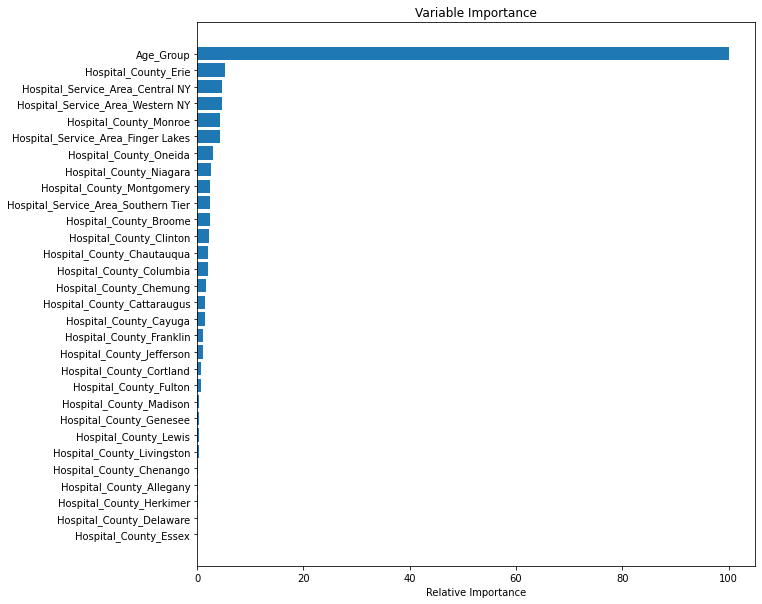

In [14]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Apply Logistic Regression

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train) 
pipe.score(X_test, y_test)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9180470793374019

In [16]:
y_pred = pipe.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {}".format(pipe.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.9180470793374019
Root Mean Squared Error: 0.35432315721449553


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
dtree = DecisionTreeClassifier(class_weight='balanced')
search_vals = dict(max_depth=[35,50,75,100], max_leaf_nodes=[800,1000,1500,2000])
dtree_search = RandomizedSearchCV(dtree, search_vals, cv=3)
search = dtree_search.fit(X_train,y_train)
search.best_params_

{'max_depth': 100, 'max_leaf_nodes': 2000}

In [17]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)